In [1]:
import os, sys, collections

if not os.path.exists('ILSVRC_data'):
    
    !tar -xf ILSVRC_data.tar

if not os.path.exists('models'):
    
    !git clone https://github.com/tensorflow/models/

if not os.path.isfile('InceptionModel/inception_v4.ckpt'):
    
    !wget -P InceptionModel http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz
    !tar -xf InceptionModel/inception_v4_2016_09_09.tar.gz -C InceptionModel
    !rm InceptionModel/inception_v4_2016_09_09.tar.gz

sys.path.append(os.path.abspath('models/research/slim'))

from scipy.misc import imread
from nets import inception_v4

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

from deepexplain.tensorflow import DeepExplain
from utils import preprocess, pixel_range

slim = tf.contrib.slim

checkpoint = 'InceptionModel/inception_v4.ckpt'

Cloning into 'models'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 24175 (delta 1), reused 1 (delta 0), pack-reused 24165
Receiving objects: 100% (24175/24175), 563.33 MiB | 10.62 MiB/s, done.
Resolving deltas: 100% (14325/14325), done.
Checking connectivity... done.
Checking out files: 100% (2767/2767), done.
--2019-01-23 10:32:00--  http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.25.112, 2404:6800:4004:800::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.25.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171177982 (163M) [application/x-tar]
Saving to: 'InceptionModel/inception_v4_2016_09_09.tar.gz'

inception_v4_2016_0 100%[===================>] 163.25M  27.1MB/s    in 7.2s    

2019-01-23 10:32:09 (22.6 MB/s) - 'InceptionModel/ince

In [2]:
def load_images(img_dir, img_size=(299,299)):
    
    def file_number(x):
        
        return int(x.split('.')[0])

    filenames = sorted(os.listdir(img_dir), key=file_number)
    filenames_valid = []
    images = []
    
    for file in filenames:
        
        try:
            
            image = PIL.Image.open(img_dir + file)
            image = np.array(image.resize(img_size, PIL.Image.ANTIALIAS))
            
            if image.ndim < 3 or (image.ndim == 3 and image.shape[-1] != 3):
                
                raise Exception('Invalid Image')
            
            images.append(image)
            filenames_valid.append(file)
            
        except:
            
            continue
    
    images = [image for image in images if len(image.shape) == 3]
    images = np.array(images)
    images = images / 127.5 - 1.0
    
    return filenames_valid, images

LABELS_LOC='InceptionModel/imagenet_comp_graph_label_strings.txt'
label_map = np.array(open(LABELS_LOC).read().split('\n'))

### Attribution Map Generation

In [3]:
tf.reset_default_graph()
sess = tf.Session()

with DeepExplain(session=sess, graph=sess.graph) as de:
    
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception_v4.inception_v4_arg_scope()):
        _, end_points = inception_v4.inception_v4(X, num_classes=1001, is_training=False)

    logits = end_points['Logits']
    yv = tf.reduce_max(logits, 1)
    yi = tf.argmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)
    
    filenames, xs = load_images('ILSVRC_data/threshold/')
    labels = sess.run(yi, feed_dict={X: xs})
    
    attribution_methods = [
                           (r'$\tau = 0$', 'rectgradconst'),
                           (r'$q = 0$'   , 0),
                           (r'$q = 10$'  , 10),
                           (r'$q = 20$'  , 20),
                           (r'$q = 80$'  , 80),
                           (r'$q = 90$'  , 90),
                           (r'$q = 95$'  , 95),
                           (r'$q = 99$'  , 99)
                          ]

    attribution_methods = collections.OrderedDict(attribution_methods)
    
    attributions = collections.OrderedDict()
    
    for k, v in attribution_methods.items():
        
        print('Running {} explanation method'.format(k))
        
        if v == 'rectgradconst':
            attribution = de.explain(v, yv, X, xs, tau=0)
        else:
            attribution = de.explain('rectgrad', yv, X, xs, percentile=v)
        
        attributions[k] = preprocess(attribution, 0.5, 99.5)
    
    print('Done!')

INFO:tensorflow:Restoring parameters from InceptionModel/inception_v4.ckpt
Running $\tau = 0$ explanation method
Running $q = 0$ explanation method
Running $q = 10$ explanation method
Running $q = 20$ explanation method
Running $q = 80$ explanation method
Running $q = 90$ explanation method
Running $q = 95$ explanation method
Running $q = 99$ explanation method
Done!


### Attribution Map Visualization

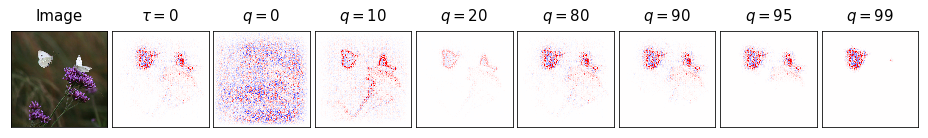

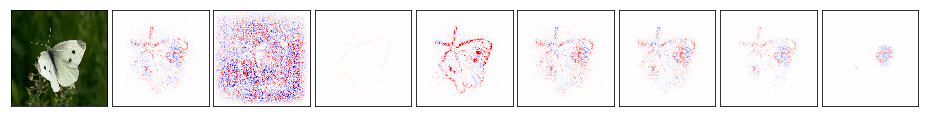

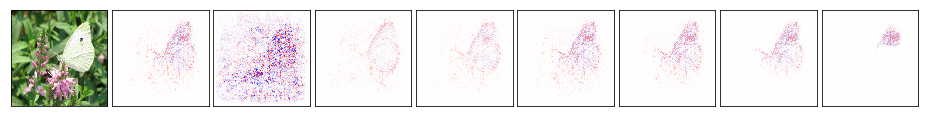

In [4]:
for i, xi in enumerate(xs):
    
    plt.figure(figsize=(13,6))
    
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    
    plt.subplot(1, 9, 1)
    plt.imshow(xi)
    plt.xticks([])
    plt.yticks([])
    
    if i == 0:
        plt.title('Image', fontsize=15, pad=10)
    
    for j, (method, attr) in enumerate(attributions.items()):
        
        plt.subplot(1, 9, j + 2)
        v, cmap = pixel_range(attr)
        plt.imshow(attr[i], vmin=v[0], vmax=v[1], cmap=cmap)
        plt.xticks([])
        plt.yticks([])
        
        if i == 0:
            plt.title(method, fontsize=15, pad=10)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    
    plt.show()